In [1]:
"""
ViT(Vision Transformer)는 컴퓨터 비전 분야에서 트랜스포머를 적용하는 개념이다
즉, 자연어 처리에서 RNN을 물리치고 왕좌에 오른 트랜스포머를 이미지에도 
적용하려는 아이디어를 구현한 것이다
2020년에 발표된 논문을 바탕으로 간단하게 재구성해서 적용한다
"""

"""
이미지를 여러 개의 패치(patch)단위로 나누고, 순서대로 포지션에 대한 인코딩한 값을 
더하여 트랜스포머에 넣어서 결과를 예측하는 개념이다
다음과 같이 간단한 코드로 구현해 보자
CIFAR-10 데이터셋을 사용한다 이미지 크기는(32, 32, 3)이고
패치의 크기를 4픽셀로 정하기로 한다 
가로, 세로 각각 4픽셀로 나누면 8개로 구분이 되고 
전체 이미지는 64조각(패치)이 된다 
각 패치는 (4, 4, 3)형태를 갖는다
"""
#기본 설정
import numpy as np
import tensorflow as tf

num_classes = 10
input_shape = (32, 32, 3)
learning_rate = 0.0001
batch_size = 64
epoch_num= 20
num_heads = 8
trans_num = 8
img_patch_size = 4
p_i_num=int(32*32/4/4)
proj_num=32
class_num =10


In [2]:
"""
케라스 함수형 API를 활용하여 모델 구조를 정의한다. 원본 이미지와 각 이미지를 구성하는
64개의 패치의 위치 인덱스를 입력 받는다. tf.image 모듈의 extract_patches 함수를 사용하여,
원본 이미지를 64개 패리로 분할한다. 분할된 각 패치를 reshape 함수를 사용하여 크기가 
48(4 * 4* 3)인 1차원 배열로 펼쳐 준다. 다시 트랜스포머의 입력 형태인 크기 32로 줄인다
채널이 1개인 위치 인덱스 배열도 Embedding 레이어를 거쳐서 채널 32로 늘린다
패치 배열과 인덱스 배열을 더해서 트랜스포머의 입력으로 사용한다
트랜스포머를 거쳐서 나온 출력을 다시 완전연결층을 거쳐서 최종 분류한다
"""
# 데이터 다운로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 인코딩 값 정의
position_input = [range(64) for i in range(50000)]
position_input = np.array(position_input)
position_input = np.reshape(position_input, (50000,64,1))

# 모델 정의
i = tf.keras.Input(shape = input_shape)
p_i = tf.keras.Input(shape=(p_i_num,1))
out_patch = tf.image.extract_patches(images=i,
            sizes=[1, img_patch_size, img_patch_size, 1],
            strides=[1, img_patch_size, img_patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID")
out = tf.keras.layers.Reshape([-1,img_patch_size*img_patch_size*3])(out_patch)
p_out = tf.keras.layers.Embedding(p_i_num, proj_num)(p_i)
p_out = tf.keras.layers.Reshape([-1,proj_num])(p_out)
out = tf.keras.layers.Dense(proj_num)(out)
out = tf.keras.layers.Add()([out,p_out])

for _ in range(trans_num):
    out_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out)
    a_out = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, 
                                               key_dim=proj_num, 
                                               dropout=0.1)(out_1, out_1)
    out_2 = tf.keras.layers.Add()([a_out, out])
    out_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out_2)
    out_3 = tf.keras.layers.Dense(proj_num *2, activation=tf.nn.gelu)(out_3)
    out_3 = tf.keras.layers.Dropout(0.1)(out_3)
    out_3 = tf.keras.layers.Dense(proj_num, activation=tf.nn.gelu)(out_3)
    out_3 = tf.keras.layers.Dropout(0.1)(out_3)
    out = tf.keras.layers.Add()([out_3, out_2])

out = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(1024, activation=tf.nn.gelu)(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(512, activation=tf.nn.gelu)(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(class_num)(out)

vit_model = tf.keras.Model(inputs=[i,p_i], outputs=[out]) 

# 모델 요약
vit_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 8, 8, 48)    0           ['input_1[0][0]']                
 Lambda)                                                                                          
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 1)]      0           []                               
                                                                                                  
 reshape (Reshape)              (None, 64, 48)       0           ['tf.image.extract_patches[0]

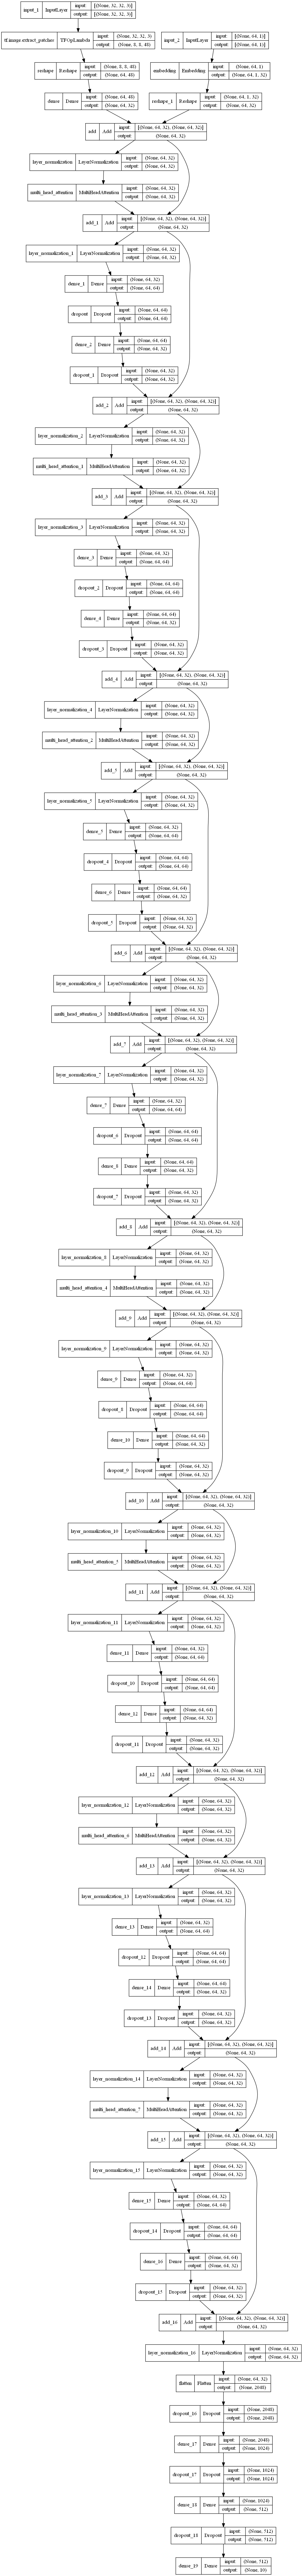

In [4]:
"""
모델 구조를 출력
"""
# 모델 구조
tf.keras.utils.plot_model(vit_model, show_shapes=True)

In [5]:
"""
원본 이미지가 64개 패치로 분할되는 것을 보여주기 위한 모델을 추가적으로 생성한다
이 모델은 앞에서 생성한 ViT 모델의 입력 이미지를 64개 패치로 구분된 이미지로 출력한다
"""
vit_image_model=  tf.keras.Model(inputs=vit_model.inputs, outputs=vit_model.layers[1].output)
img=vit_image_model.predict([x_train[0:2],position_input[0:2]])
img.shape


(2, 8, 8, 48)

(-0.5, 31.5, 31.5, -0.5)

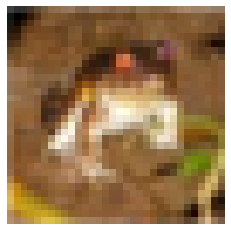

In [6]:
"""
원본 이미지를 시각화 하면 다음과 같은 개구리 사진을 알 수 있다
"""
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
image = x_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

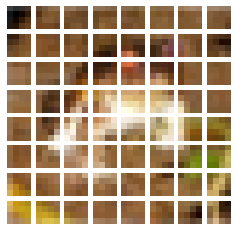

In [7]:
"""
앞의 개구리 이미지를 64개 패치로 분할하면 다음과 같다
"""
plt.figure(figsize = (4, 4))
for i in range(8):
    for j in range(8):
        ax = plt.subplot(8, 8, i*8 +j +1)
        sub_img = np.reshape(img[0, i, j, :],(4, 4, 3))
        plt.imshow(sub_img.astype("uint8"))
        plt.axis("off")

In [8]:
"""
다중 분류 문제에 맞도록 옵티마이저, 손실함수, 평가지표를 설정하고 
모델을 훈련시킨다.
평가 지표에 사용한 top-5-accuracy는 모델의 예측 확률값 기준으로 상위 5개 클래스에
해당하는지 알려준다
"""
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

vit_model.fit(x=[x_train,position_input],
             y = y_train,
             batch_size = batch_size,
             epochs = epoch_num,
             validation_split=0.3)

Epoch 1/20
547/547 [==============================] - 46s 72ms/step - loss: 2.0801 - accuracy: 0.2449 - top-5-accuracy: 0.7458 - val_loss: 1.8824 - val_accuracy: 0.3119 - val_top-5-accuracy: 0.8238
Epoch 2/20
547/547 [==============================] - 39s 71ms/step - loss: 1.7266 - accuracy: 0.3749 - top-5-accuracy: 0.8655 - val_loss: 1.6256 - val_accuracy: 0.4161 - val_top-5-accuracy: 0.8859
Epoch 3/20
547/547 [==============================] - 39s 71ms/step - loss: 1.5500 - accuracy: 0.4391 - top-5-accuracy: 0.9023 - val_loss: 1.5572 - val_accuracy: 0.4379 - val_top-5-accuracy: 0.9071
Epoch 4/20
547/547 [==============================] - 39s 71ms/step - loss: 1.4273 - accuracy: 0.4867 - top-5-accuracy: 0.9233 - val_loss: 1.4487 - val_accuracy: 0.4849 - val_top-5-accuracy: 0.9220
Epoch 5/20
547/547 [==============================] - 39s 71ms/step - loss: 1.3441 - accuracy: 0.5143 - top-5-accuracy: 0.9363 - val_loss: 1.3967 - val_accuracy: 0.5019 - val_top-5-accuracy: 0.9282
Epoch 6/20